This is a generic script for finetuning ViLT model for VQA tasks
Simply format your data as per the requirements below and this should work.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data format
* the images (stored in a single folder)
* the questions (stored in a JSON) -- with following
* the annotations (stored in a JSON) a.k.a. the answers to the questions.

Refer to https://github.com/multimodal/multimodal/blob/master/test/data/vqa2/val/v2_OpenEnded_mscoco_val2014_questions.json for a sample of how question json file should look like.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00


In [ ]:
import os
home = '/content/drive/MyDrive/ReadyForFineTuning/Winoground/'
imroot = home+'merged_images'
os.chdir(home)

This piece of code converts data in VLQAv1 into desired format. If multiple images are there, it automatically merges them into one.

In [ ]:
prefix = 'winoground'

In [ ]:
#!rm /content/blocksworld_truncated_viltft.jsonl

import json
import ast

dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "clevrhyp", "license": {}, "data_subtype": prefix,
    "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  for i in data:
    ijson = json.loads(i)
    imlist = ast.literal_eval(ijson['images'])
    anslist = [str(i) for i in ast.literal_eval(ijson['answer_choices'])]
    #if len(imlist) == 2:
    #  mpath = mergeim(imlist[0], imlist[1])
    # mpath
    dumpdict['questions'].append( { "image_id": imroot+'/Merged_'+imlist[0].replace("./images/","",1).replace(".jpg","",1).replace(".png","",1)+"#"+imlist[1].replace("./images/","",1), "question": ijson['question']+" "+ijson['passage'], "question_id": ijson['qid'], "answer_choices": anslist, "answer_id": int(ijson['answer']) } )

with open('/content/'+prefix+'_viltft.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

252
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'clevrhyp', 'license': {}, 'data_subtype': 'recipe', 'questions': [{'image_id': '/content/drive/MyDrive/ReadyForFineTuning/RecipeQA/merged_images/Merged_perfect-snickerdoodles_III#perfect-snickerdoodles_II.jpg', 'question': 'Choose the correct order of steps I-IV in order to make perfect snickerdoodles. Left image is denoted by [0] and right image is denoted by [1]. III. Image [0] II. Image [1] I. Preheat the oven to 375 degrees f. Mix the flour, baking soda, cream of tartar and 1 tsp of cinnamon in a small bowl. IV. In a large mixer, combine the butter and 1 cup of the sugar. Slowly whisk in the eggs and vanilla. The resulting mixture will be thin and light peach.', 'question_id': 1966, 'answer_choices': ['I-II-IV-III', 'I-IV-III-II', 'II-III-I-IV', 'II-I-IV-III'], 'answer_id': 1}, {'image_id': '/content/drive/MyDrive/ReadyForFineTuning/RecipeQA/merged_images/Merged_drill-powered-meat-grinder_I#drill-powered-meat-grinder_IV.jpg'

### Read questions

First, we read the questions.

In [ ]:
import json
f = open('/content/'+prefix+'_viltft.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 252


That's quite a lot! Let's take a look at the first one:

In [ ]:
questions[0]

{'image_id': '/content/drive/MyDrive/ReadyForFineTuning/RecipeQA/merged_images/Merged_perfect-snickerdoodles_III#perfect-snickerdoodles_II.jpg',
 'question': 'Choose the correct order of steps I-IV in order to make perfect snickerdoodles. Left image is denoted by [0] and right image is denoted by [1]. III. Image [0] II. Image [1] I. Preheat the oven to 375 degrees f. Mix the flour, baking soda, cream of tartar and 1 tsp of cinnamon in a small bowl. IV. In a large mixer, combine the butter and 1 cup of the sugar. Slowly whisk in the eggs and vanilla. The resulting mixture will be thin and light peach.',
 'question_id': 1966,
 'answer_choices': ['I-II-IV-III',
  'I-IV-III-II',
  'II-III-I-IV',
  'II-I-IV-III'],
 'answer_id': 1}

In [ ]:
from os import listdir
from os.path import isfile, join

# -- CHANGE THIS BASED ON WHERE IMAGES ARE STORED --
#root = home+'images'

file_names = [f for f in listdir(imroot) if isfile(join(imroot, f))]
print(file_names)
print(len(file_names))

['Merged_drill-powered-meat-grinder_I#drill-powered-meat-grinder_IV.jpg', 'Merged_boozy-pecan-fudge_I#boozy-pecan-fudge_III.png', 'Merged_perfect-snickerdoodles_III#perfect-snickerdoodles_II.jpg', 'Merged_garlic-spaghetti_III#garlic-spaghetti_II.png', 'Merged_vegetarian-bean-enchiladas_I#vegetarian-bean-enchiladas_IV.png', 'Merged_how-to-make-basbousa_I#how-to-make-basbousa_III.png', 'Merged_easy-dip-3_I#easy-dip-3_III.png', 'Merged_spicy-tuna-courgetti_IV#spicy-tuna-courgetti_III.png', 'Merged_wintersummer-crisp_II#wintersummer-crisp_IV.png', 'Merged_knorr-spinach-dip-for-soft-pretzels_I#knorr-spinach-dip-for-soft-pretzels_IV.png', 'Merged_sweet-sours_IV#sweet-sours_III.png', 'Merged_iced-coffee-frappe_IV#iced-coffee-frappe_III.png', 'Merged_droplets-1_I#droplets-1_IV.png', 'Merged_how-to-make-fried-ice-cream_III#how-to-make-fried-ice-cream_II.png', 'Merged_homemade-olive-oil-spread_III#homemade-olive-oil-spread_II.png', 'Merged_nacho-not-your-average-nachos_IV#nacho-not-your-average-

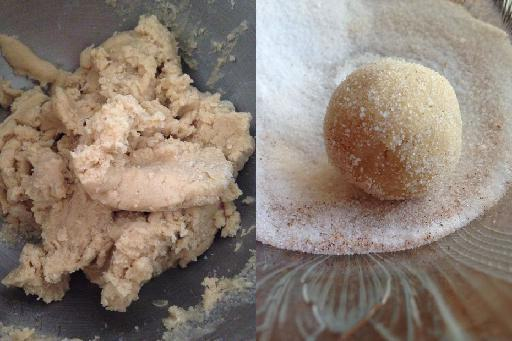

In [ ]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [ ]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

## Create PyTorch dataset

Next, we create a regular [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We leverage `ViltProcessor` to prepare each image + text pair for the model, which will automatically:
* leverage `BertTokenizerFast` to tokenize the text and create `input_ids`, `attention_mask` and `token_type_ids`
* leverage `ViltFeatureExtractor` to resize + normalize the image and create `pixel_values` and `pixel_mask`.

Note that the docs of `ViltProcessor` can be found [here](https://huggingface.co/docs/transformers/master/en/model_doc/vilt#transformers.ViltProcessor).

We also add the labels. This is a PyTorch tensor of shape `(num_labels,)` that contains the soft encoded vector.

In [ ]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor): #annotations
        self.questions = questions
        #self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        # get image + text
        #annotation = self.annotations[idx]
        questions = self.questions[idx]
        #image = Image.open(id_to_filename[annotation['image_id']])
        image = Image.open(questions['image_id']).convert("RGB")
        text = questions['question']
        #print(image)
        #print(text)
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        #labels = questions['answer_choices'][questions['answer_id']] #annotation['labels']
        #scores = [1.0] #annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        #print(len(questions['answer_choices']))
        targets = torch.zeros(len(questions['answer_choices']))
        targets[questions['answer_id']] = 1.0
        #print(targets)
        #for label, score in zip(labels, scores):
        #      targets[label] = score
        encoding["labels"] = targets
        #print(encoding)
        #print(labels)
        #print(scores)

        return encoding

In [ ]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

In [ ]:
dataset = VQADataset(questions=questions,processor=processor) ##annotations=annotations[:10],

In [ ]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [ ]:
processor.decode(dataset[0]['input_ids'])

'[CLS] choose the correct order of steps i - iv in order to make perfect snickerdoodles. left image is denoted by [ 0 ] and right image is denoted by [ 1 ] [SEP]'

In [ ]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()

## Define model

Here we define a `ViltForQuestionAnswering` model, with the weights of the body initialized from dandelin/vilt-b32-mlm, and a randomly initialized classification head. We also move it to the GPU, if it's available.

In [ ]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm", num_labels=4)

model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.3.weight', 'classifier.1.weight', 'classifier.3.bias', 'classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  #print(pixel_values)
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  #encoding = processor.feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = torch.stack(pixel_values) #encoding['pixel_values']
  #batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

Let's verify a batch:

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([1, 40])
attention_mask torch.Size([1, 40])
token_type_ids torch.Size([1, 40])
pixel_values torch.Size([1, 3, 224, 608])
labels torch.Size([1, 4])


## Train a model

Finally, let's train a model!

In [ ]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)

# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/252 [00:00<?, ?it/s]

Loss: 1.5028982162475586
Loss: 11.319748878479004
Loss: 3.9752821922302246
Loss: 6.424294948577881
Loss: 2.620736598968506
Loss: 0.971038818359375
Loss: 5.960447311401367
Loss: 10.661296844482422
Loss: 11.114274978637695
Loss: 16.628318786621094
Loss: 7.3714823722839355
Loss: 2.5043134689331055
Loss: 16.051115036010742
Loss: 0.14326642453670502
Loss: 20.69423484802246
Loss: 0.24744835495948792
Loss: 9.755778312683105
Loss: 12.333834648132324
Loss: 1.4954713582992554
Loss: 4.615893363952637
Loss: 5.944899559020996
Loss: 2.849034070968628
Loss: 2.2823657989501953
Loss: 1.7791029214859009
Loss: 2.7784504890441895
Loss: 2.576122283935547
Loss: 2.1675844192504883
Loss: 16.665943145751953
Loss: 15.852804183959961
Loss: 8.668210983276367
Loss: 0.23512010276317596
Loss: 0.44021928310394287
Loss: 6.978308200836182
Loss: 6.224437236785889
Loss: 1.121290922164917
Loss: 0.8380856513977051
Loss: 7.123882293701172
Loss: 6.312680244445801
Loss: 3.8962531089782715
Loss: 2.612571954727173
Loss: 2.28108

  0%|          | 0/252 [00:00<?, ?it/s]

Loss: 2.4205572605133057
Loss: 2.7287445068359375
Loss: 1.7793097496032715
Loss: 2.7560203075408936
Loss: 2.7049055099487305
Loss: 1.8836098909378052
Loss: 1.8028373718261719
Loss: 2.4595870971679688
Loss: 2.404157876968384
Loss: 2.4751498699188232
Loss: 3.157649040222168
Loss: 2.4561526775360107
Loss: 3.1375346183776855
Loss: 2.225438117980957
Loss: 1.8160394430160522
Loss: 1.8479114770889282
Loss: 2.3054094314575195
Loss: 2.900141954421997
Loss: 2.8186774253845215
Loss: 1.9129706621170044
Loss: 2.3460640907287598
Loss: 2.2995057106018066
Loss: 2.4406793117523193
Loss: 2.4031615257263184
Loss: 2.3777623176574707
Loss: 2.2107298374176025
Loss: 2.3910465240478516
Loss: 2.228541135787964
Loss: 2.1578612327575684
Loss: 2.4335951805114746
Loss: 2.693681001663208
Loss: 1.9211022853851318
Loss: 2.801091194152832
Loss: 2.795987606048584
Loss: 1.7367777824401855
Loss: 1.6687901020050049
Loss: 1.5749545097351074
Loss: 1.4615033864974976
Loss: 2.802168369293213
Loss: 2.841135025024414
Loss: 3.01

  0%|          | 0/252 [00:00<?, ?it/s]

Loss: 1.7364509105682373
Loss: 2.5245018005371094
Loss: 2.5676398277282715
Loss: 2.510684013366699
Loss: 2.4222326278686523
Loss: 1.779836893081665
Loss: 2.573354959487915
Loss: 2.1618528366088867
Loss: 2.604996681213379
Loss: 2.0102381706237793
Loss: 1.921843409538269
Loss: 1.8120858669281006
Loss: 1.6838066577911377
Loss: 2.2539796829223633
Loss: 3.05808687210083
Loss: 3.0715794563293457
Loss: 1.3311264514923096
Loss: 1.2716922760009766
Loss: 1.1931722164154053
Loss: 3.2085700035095215
Loss: 3.0094478130340576
Loss: 3.2367818355560303
Loss: 3.0062673091888428
Loss: 2.9155945777893066
Loss: 2.985248327255249
Loss: 2.9012386798858643
Loss: 2.8407037258148193
Loss: 2.4739773273468018
Loss: 2.5838623046875
Loss: 2.6249899864196777
Loss: 2.2791497707366943
Loss: 2.366382122039795
Loss: 2.165511131286621
Loss: 2.2500948905944824
Loss: 2.4556217193603516
Loss: 2.398054599761963
Loss: 2.3910398483276367
Loss: 2.3310630321502686
Loss: 2.2449212074279785
Loss: 2.137862205505371
Loss: 2.2145931

  0%|          | 0/252 [00:00<?, ?it/s]

Loss: 2.4810290336608887
Loss: 2.3002068996429443
Loss: 2.3348097801208496
Loss: 2.241359233856201
Loss: 2.324483871459961
Loss: 2.036625623703003
Loss: 2.310055732727051
Loss: 2.1036901473999023
Loss: 3.037158489227295
Loss: 2.2204337120056152
Loss: 3.0086395740509033
Loss: 2.1307497024536133
Loss: 2.1518406867980957
Loss: 2.14007830619812
Loss: 2.850371837615967
Loss: 2.1778783798217773
Loss: 2.021088123321533
Loss: 2.288290500640869
Loss: 1.9969685077667236
Loss: 2.678722858428955
Loss: 2.2235946655273438
Loss: 2.2179312705993652
Loss: 1.9631636142730713
Loss: 2.4016969203948975
Loss: 2.569188117980957
Loss: 2.534733295440674
Loss: 2.4693918228149414
Loss: 2.442509651184082
Loss: 2.435380697250366
Loss: 2.2717342376708984
Loss: 2.386990547180176
Loss: 2.199126720428467
Loss: 2.3124313354492188
Loss: 2.2991764545440674
Loss: 2.2581541538238525
Loss: 2.1948113441467285
Loss: 2.322387933731079
Loss: 2.0547311305999756
Loss: 2.337538242340088
Loss: 2.4539084434509277
Loss: 1.88464188575

## Inference

Let's verify whether the model has actually learned something:

# Single Instance Inference

In [ ]:
exid = 1
example = dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [ ]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [ ]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 2
Ground-truth answer: 2


# Batch Inference

In [ ]:
import csv
tasktype = "2way"
filprefix = prefix+"_"+tasktype

count = 0
st = 0
end = 252
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end):
    correctness = 0
    example = dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    #print([exid,predicted_class, gtclass,correctness])
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])
    acc = count*100/(end-st+1)

print(count)
print(end-st+1)
print(acc)

224
253
88.53754940711462
